In [1]:
    import warnings
import pandas as pd
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
# pd.options.display.max_columns = 20
warnings.filterwarnings("ignore")
import glob
from sklearn import preprocessing
import networkx as nx
import numpy as np

global label
import argparse
import os.path
from os import path
from itertools import combinations
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.spatial import distance
import scipy
import itertools

/home/leonidas/PycharmProjects/GNN_based_NILM/notebooks


In [2]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = '../low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 



In [3]:
def read_merge_data(house):
    path = '../low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [4]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


In [5]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



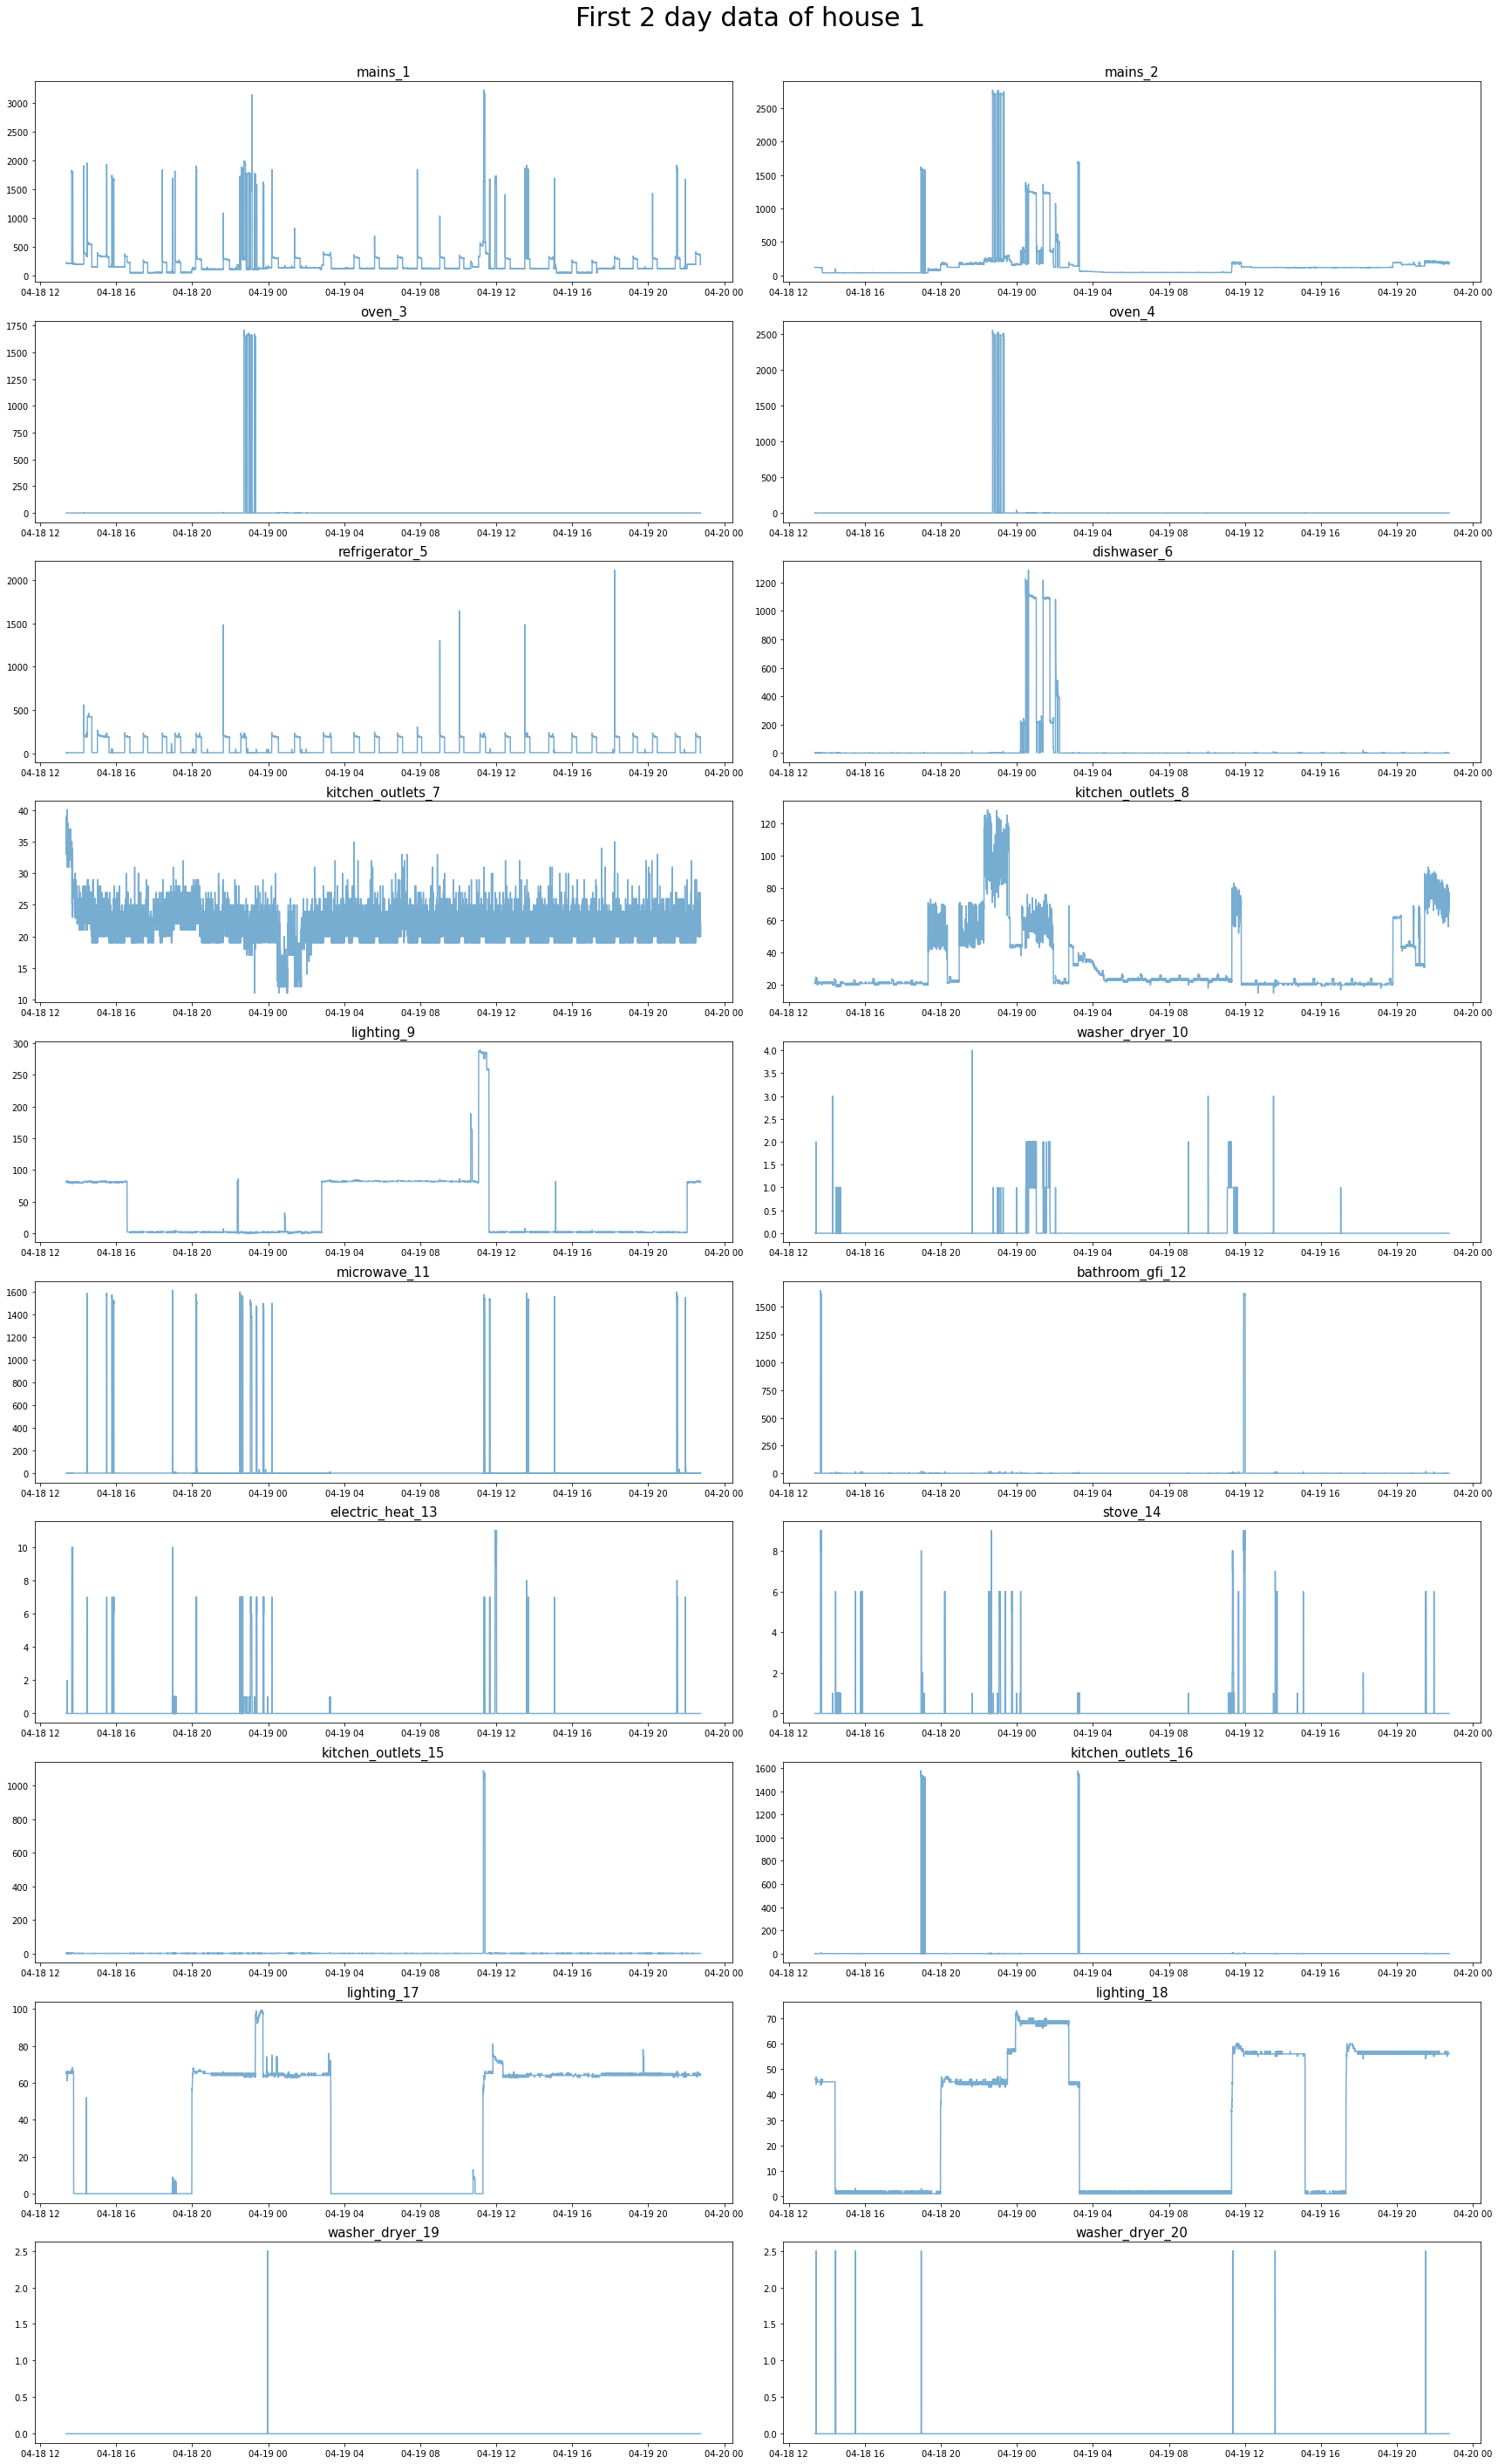

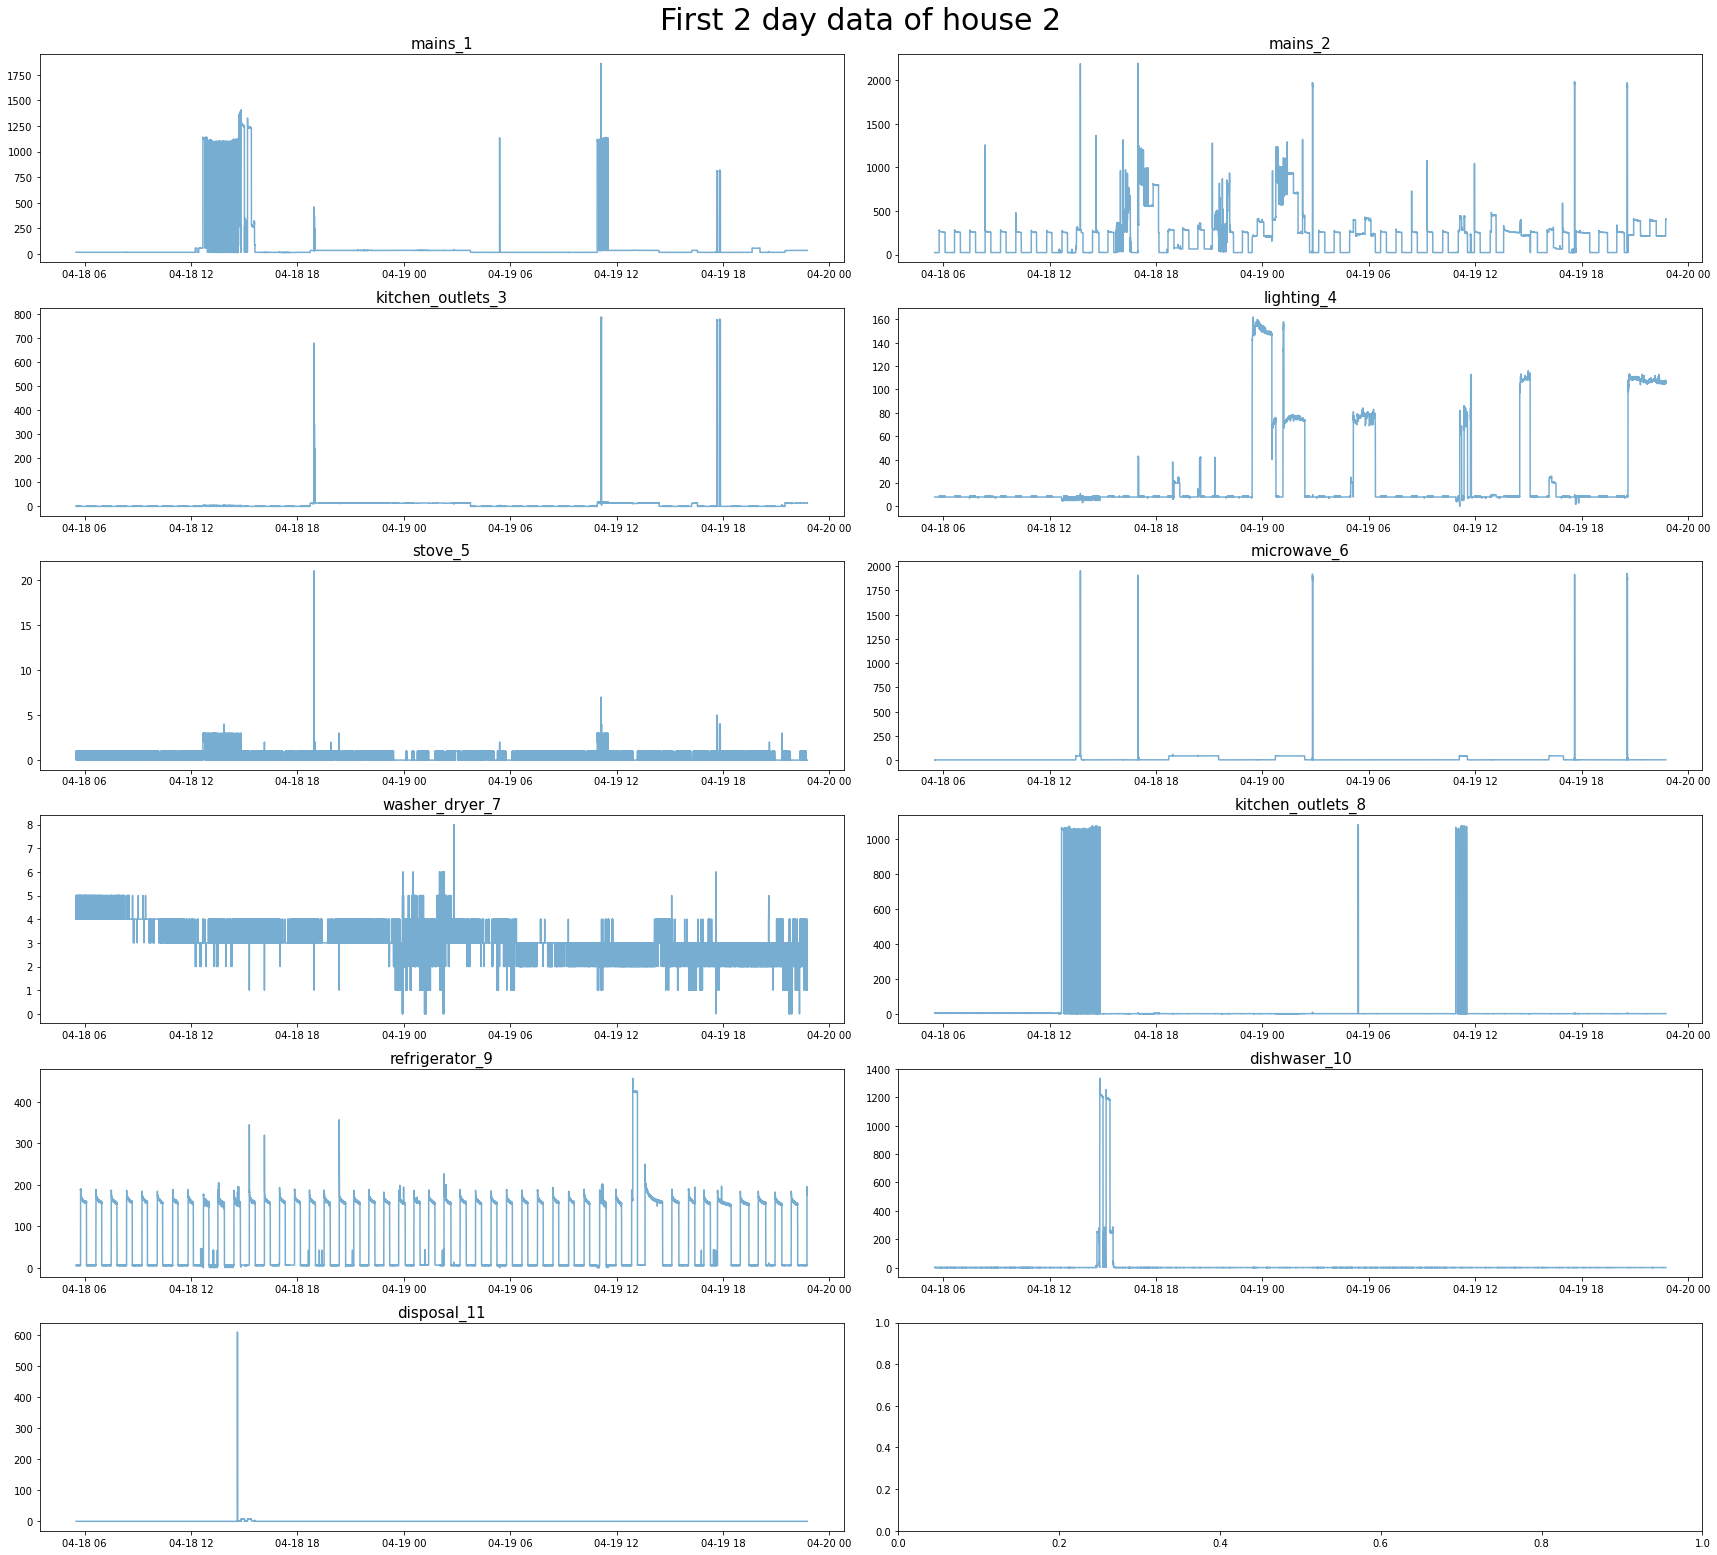

In [6]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,3):
    plot_df(df[i].loc[:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5, 1.0, 'House 2')

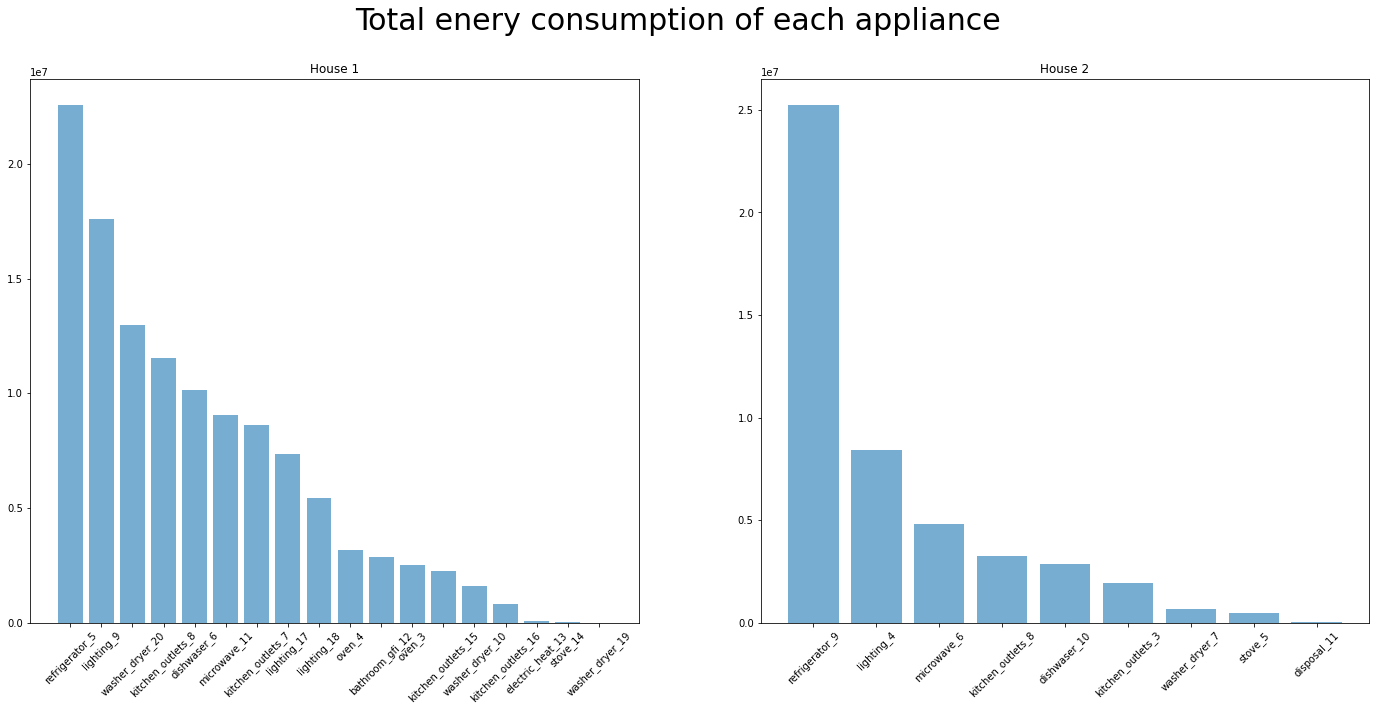

In [7]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

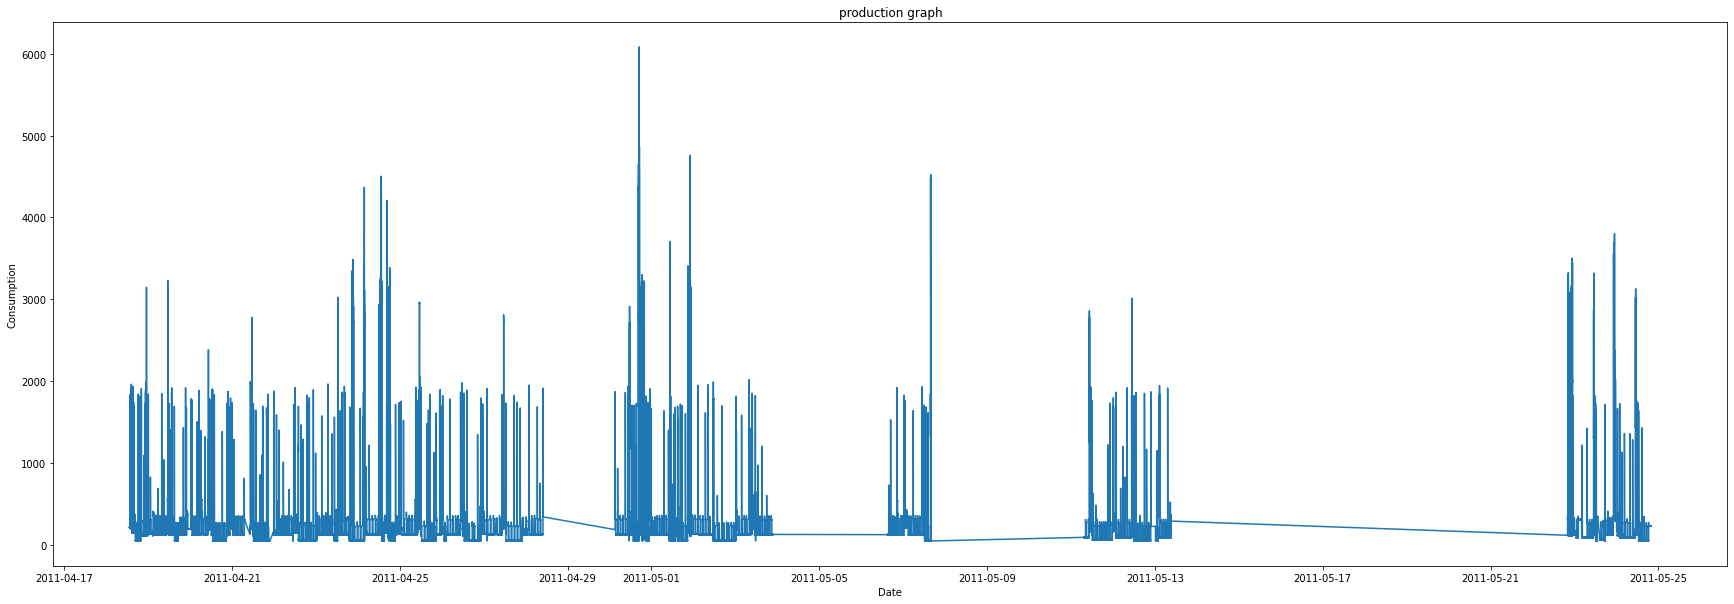

In [9]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(df[1]['mains_1'])

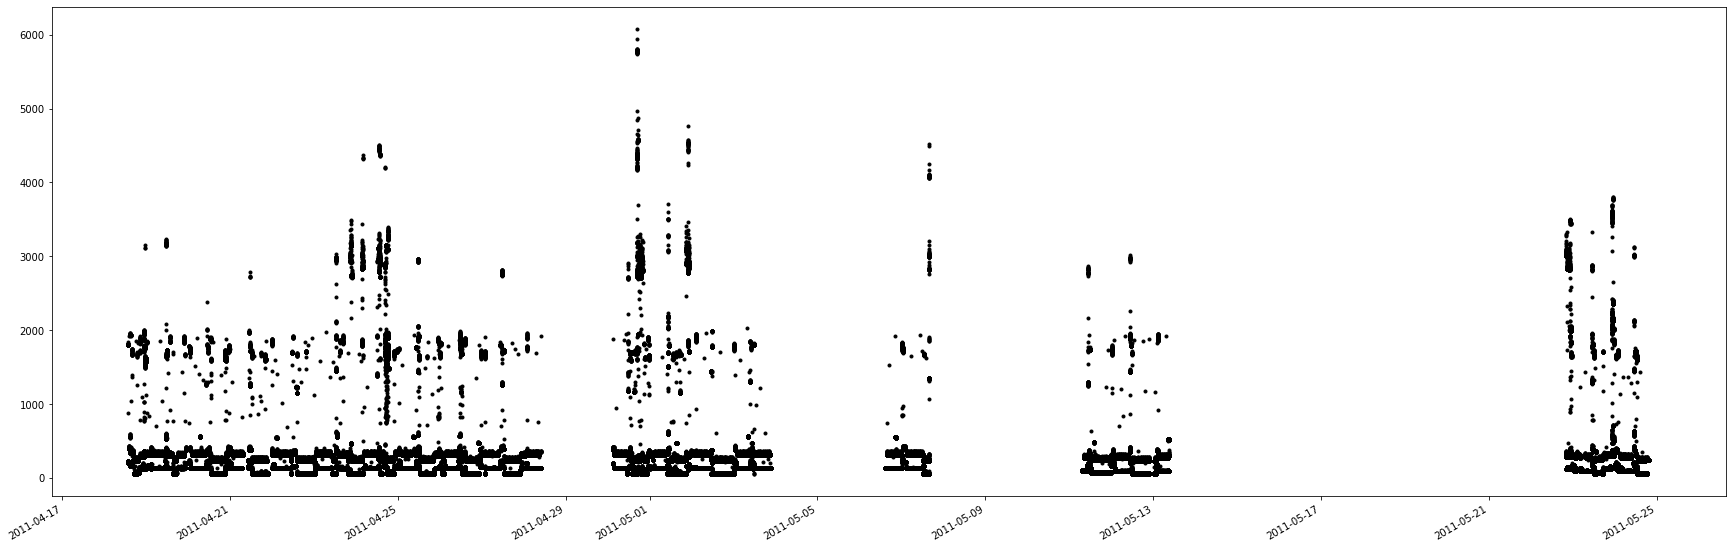

In [10]:
df[1]['mains_1'].plot(style='k.')
plt.show()

In [11]:
df[1]

,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-04-18 13:22:13,222.20,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:16,223.17,119.19,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:20,223.60,118.92,0.0,0.0,6.0,0.0,34.0,22.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:23,222.91,119.16,0.0,0.0,6.0,1.0,35.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,65.0,46.0,0.0,0.0
2011-04-18 13:22:26,222.94,118.83,0.0,0.0,6.0,0.0,34.0,21.0,81.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0,65.0,46.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-24 19:56:20,235.73,38.65,0.0,0.0,186.0,1.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:23,235.03,38.66,0.0,0.0,187.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
house_1 = df[1]

In [13]:
house_1['mains_1']

2011-04-18 13:22:13    222.20
2011-04-18 13:22:16    223.17
2011-04-18 13:22:20    223.60
2011-04-18 13:22:23    222.91
2011-04-18 13:22:26    222.94
                        ...  
2011-05-24 19:56:20    235.73
2011-05-24 19:56:23    235.03
2011-05-24 19:56:27    235.46
2011-05-24 19:56:30    235.98
2011-05-24 19:56:34    235.29
Name: mains_1, Length: 406748, dtype: float64

In [14]:
mains_1 = pd.DataFrame(columns=['Date', 'consumption'])
mains_1['Date'] = house_1.index
mains_1['consumption'] = house_1['mains_1'].values
# mains_1 = mains_1.dropna()
mains_1['Date'] = pd.to_datetime(mains_1['Date'])
mains_1.set_index('Date', inplace=True) #set date as index
mains_1.shape

(406748, 1)

True

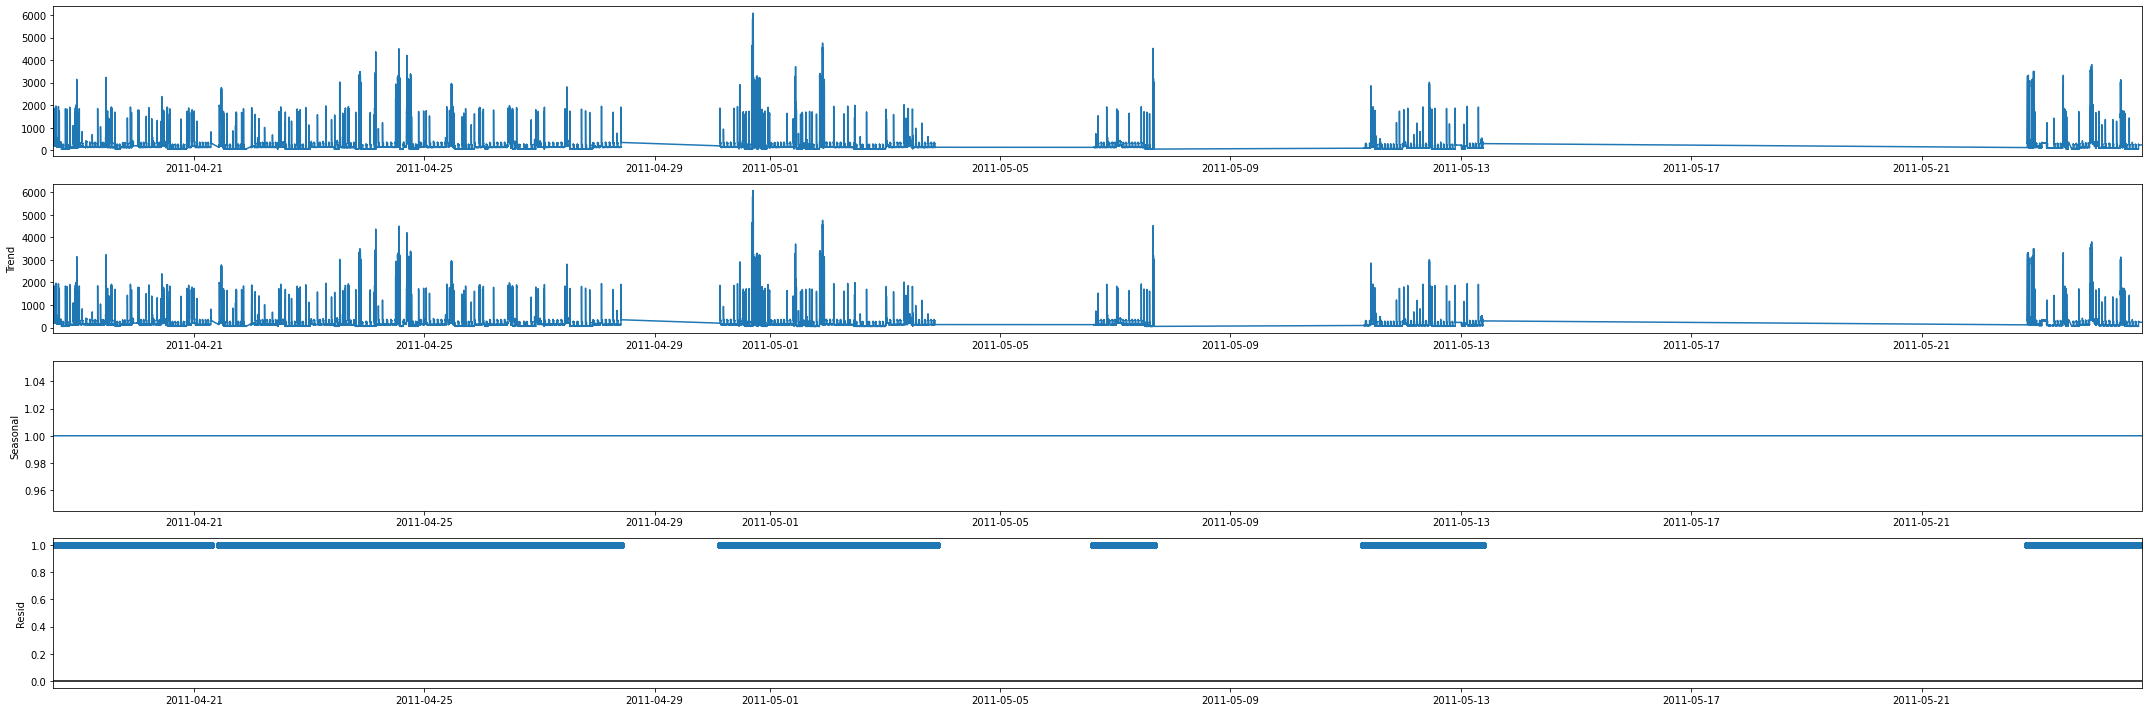

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(mains_1, model='multiplicative', period=1)
result.plot()
plt.show()

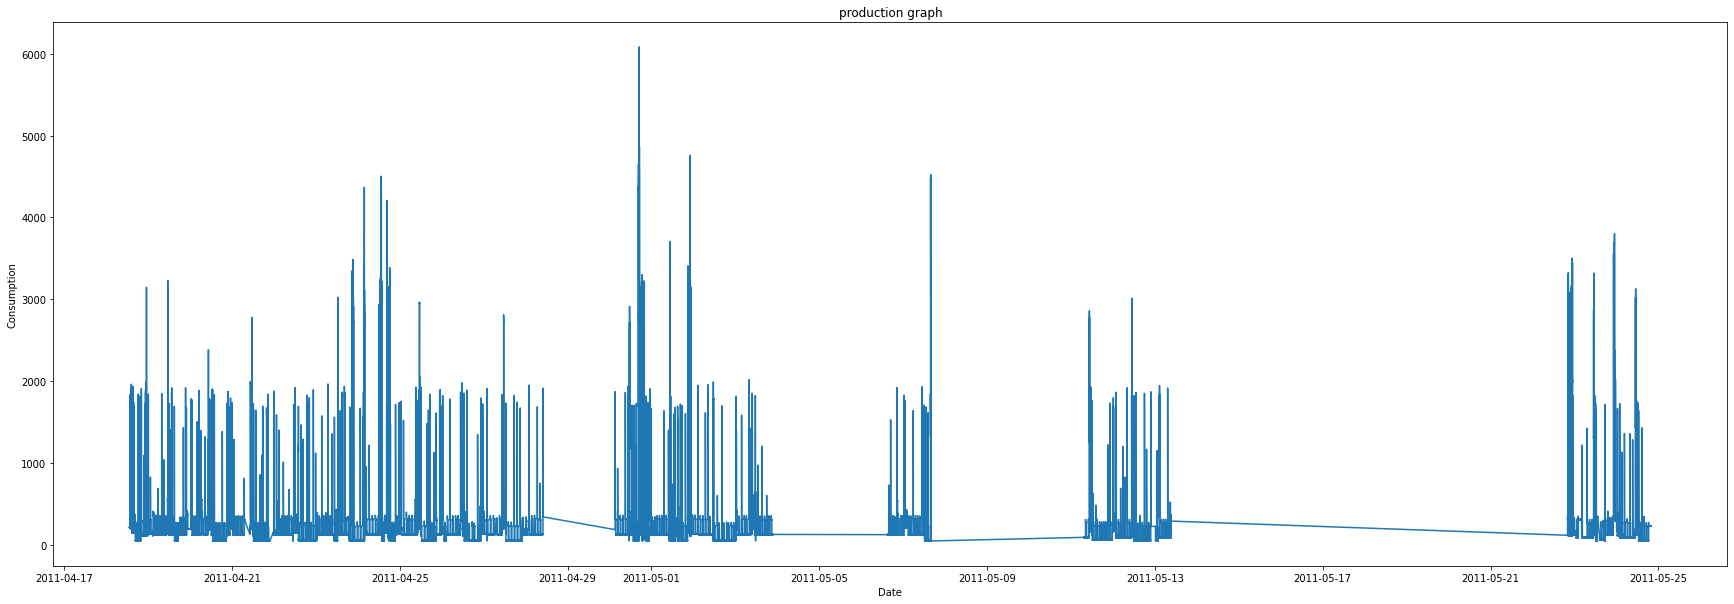

In [16]:
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(mains_1)

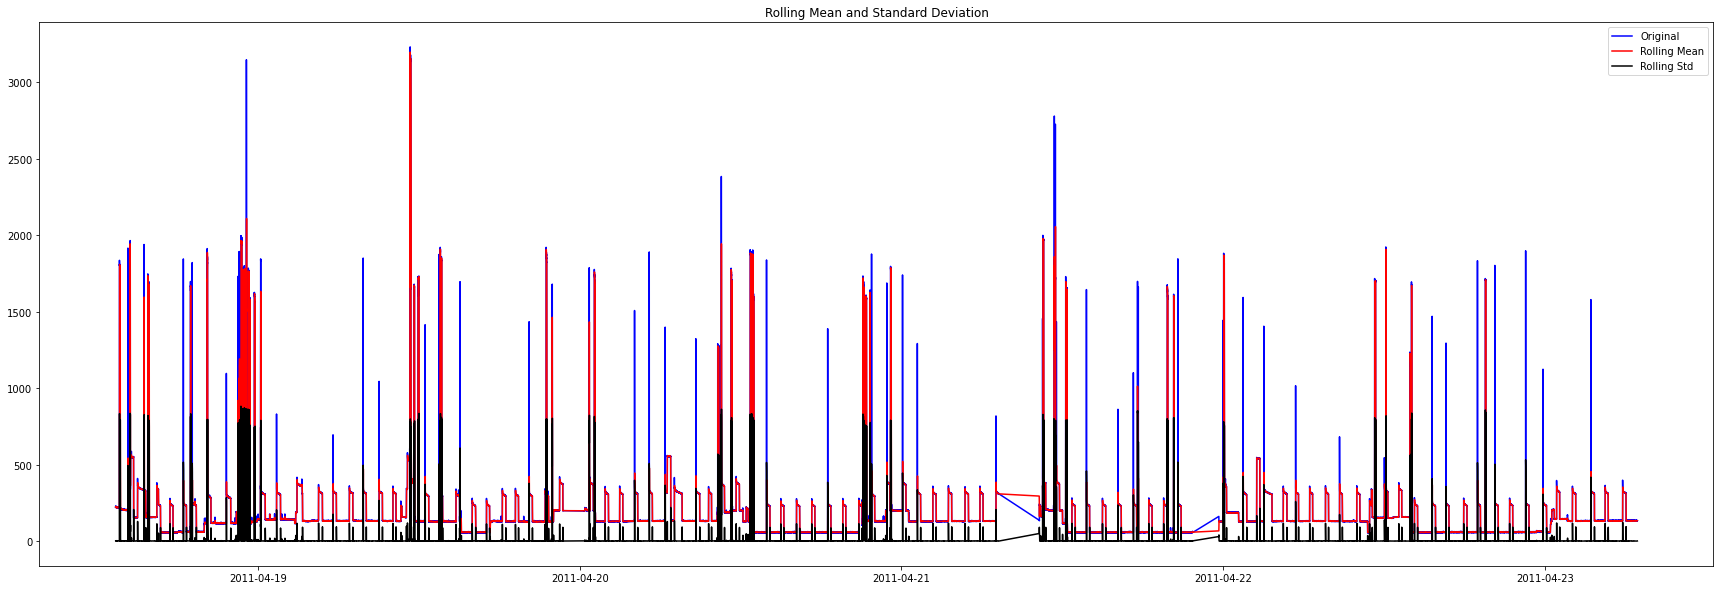

Results of dickey fuller test
Test Statistics                  -22.639241
p-value                            0.000000
No. of lags used                  68.000000
Number of observations used    99931.000000
critical value (1%)               -3.430415
critical value (5%)               -2.861569
critical value (10%)              -2.566785
dtype: float64


In [17]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(mains_1[:100000])

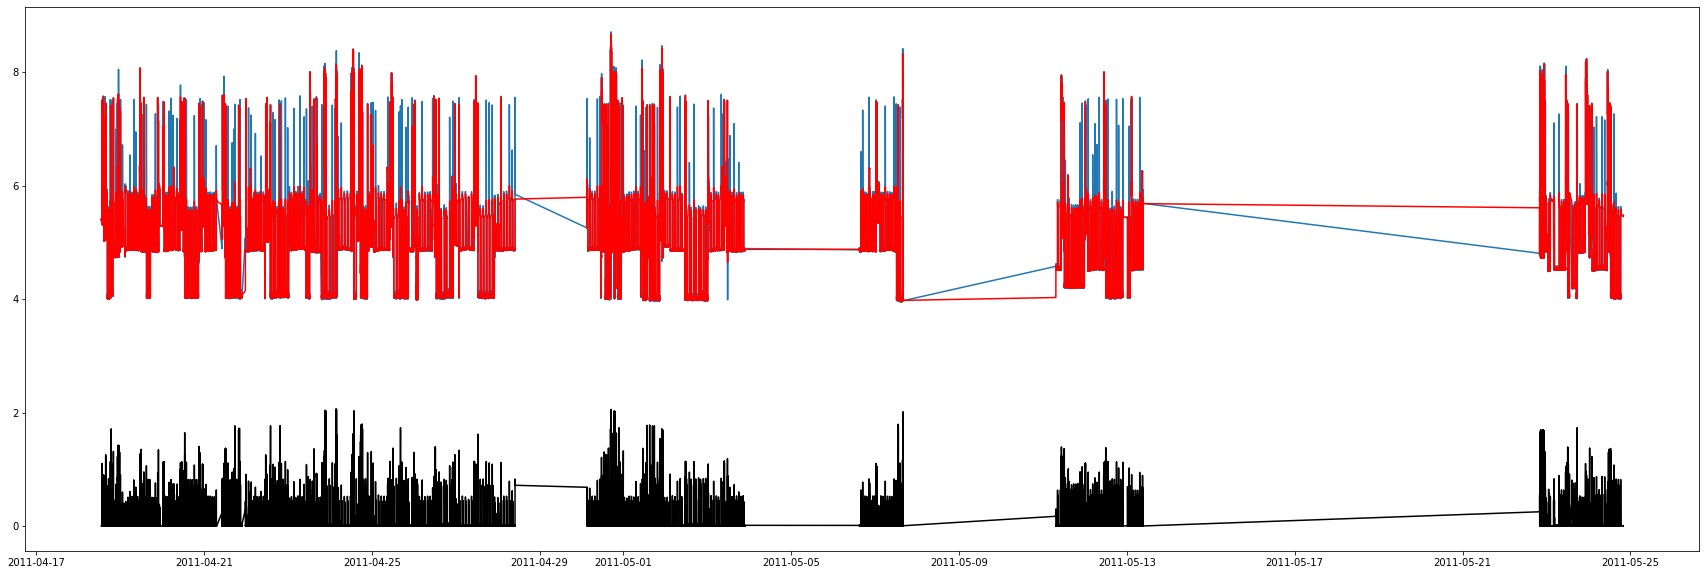

In [25]:
df_log = np.log(mains_1)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

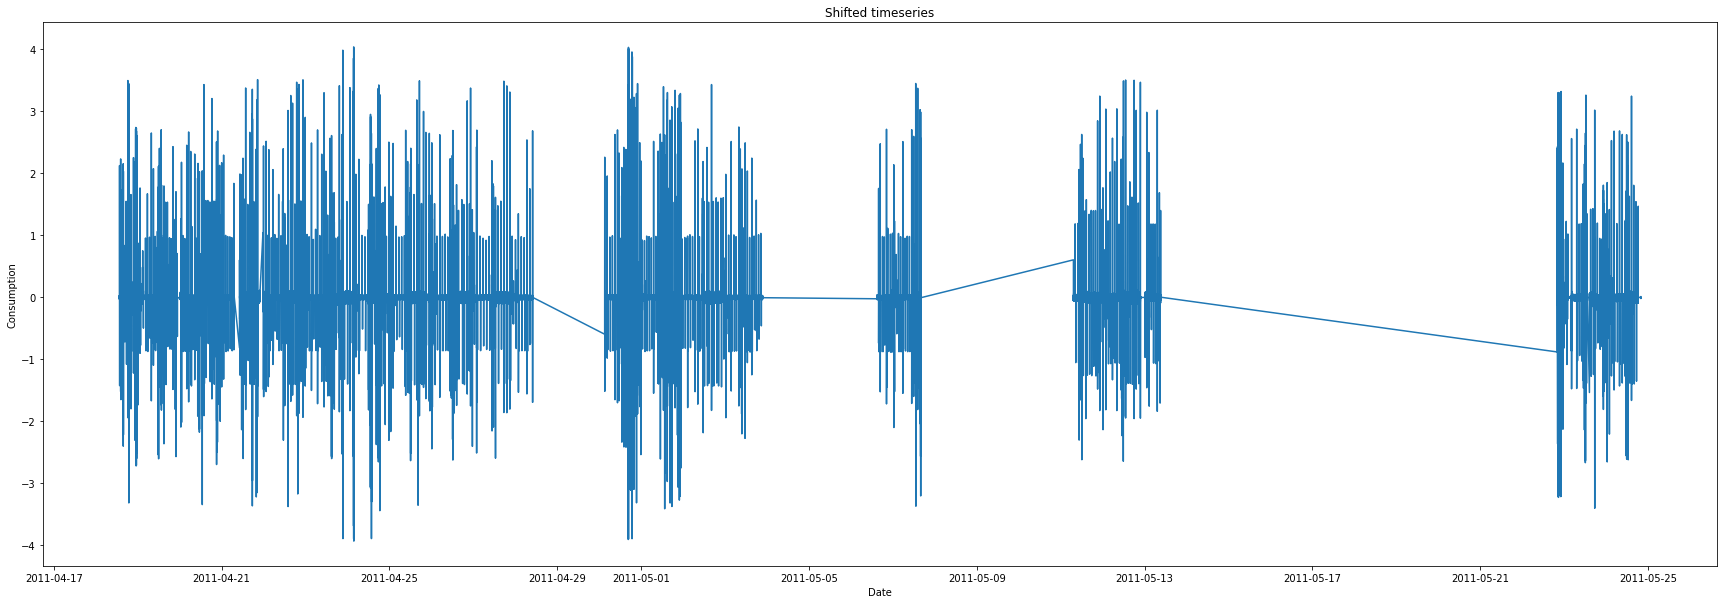

In [26]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
# test_stationarity(df_log_diff)

In [22]:
! pip install chart_studio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 405 kB/s            
     |████████████████████████████████| 26.5 MB 121 kB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=4add424d93ad91bcdfd2f8dbb4ffd53ce22e15bce4403a572b94f49f11464c9a
  Stored in directory: /home/leonidas/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


<AxesSubplot:xlabel='Date'>

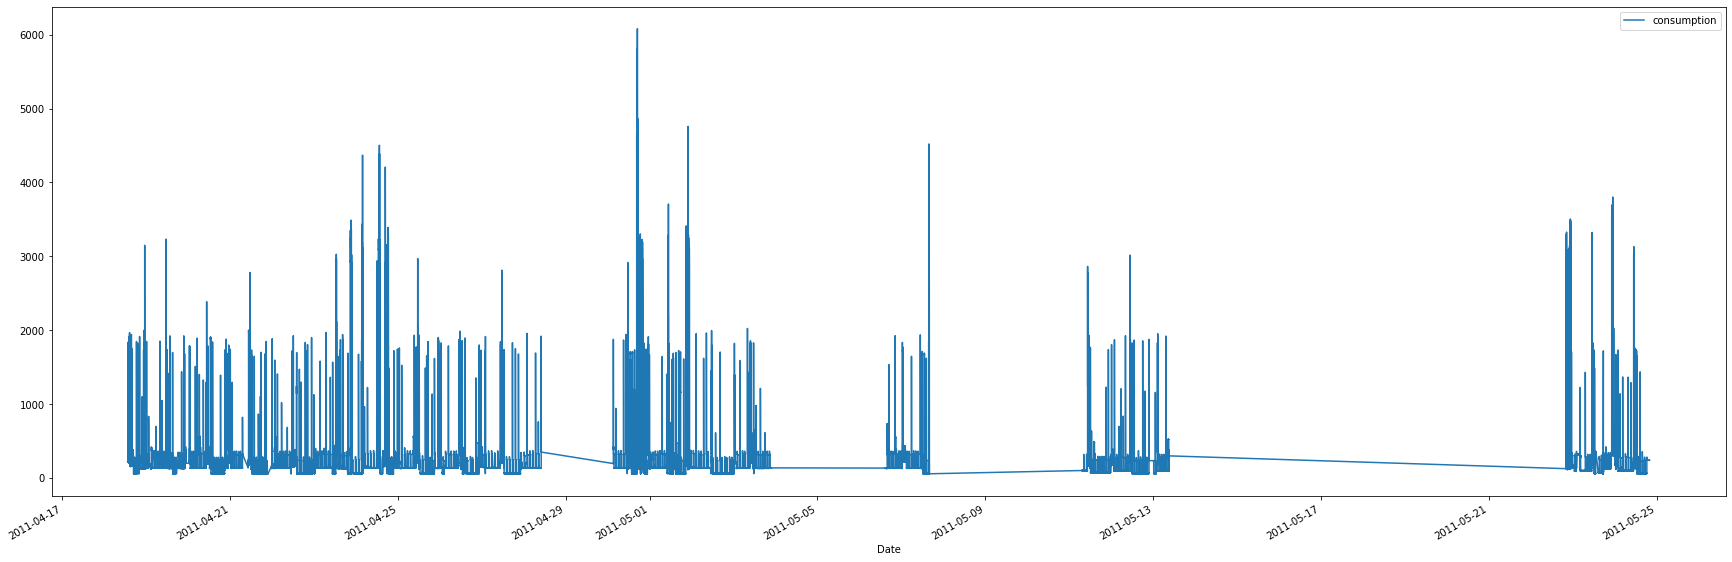

In [28]:
mains_1.plot()